# Train a regression ConvNN model using BOHB tuner

In [1]:
import sys  
sys.path.insert(0, '../../codes/')

from predict_observational_dataset_v2 import ProcessObservationalDataset
from train_regression import *
from bohb_optimizer_2 import *


2023-06-12 12:27:05.207876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [2]:
# Libraries for BOHB Package 
import logging
logging.basicConfig(level=logging.WARNING)

import argparse

import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB as BOHB
from hpbandster.examples.commons import MyWorker

from tensorflow.keras.models import load_model
import ConfigSpace as CS
from hpbandster.core.worker import Worker

# Step 1: Load the dataset

In [3]:
# original dataset
df=pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
df.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


In [4]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


In [5]:
df.iloc[::10]

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.00,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
10,5.00,1100,0.25,1.7,8.540979e-09,9.610928e-09,8.362026e-09,6.331807e-09,5.411898e-09,3.597492e-09,...,2.589948e-09,1.400508e-09,1.423739e-09,1.331622e-09,5.718932e-10,2.525684e-09,2.577776e-09,2.171606e-09,1.170498e-09,no
20,5.00,1100,0.50,1.0,2.089233e-08,2.547443e-08,2.398659e-08,1.954245e-08,1.673706e-08,1.128757e-08,...,1.030422e-08,6.744711e-09,6.570654e-09,5.994584e-09,3.266539e-09,6.722988e-09,6.756289e-09,5.708415e-09,3.422240e-09,no
30,5.00,1100,1.00,0.5,3.773544e-08,4.306029e-08,3.789344e-08,2.982717e-08,2.555826e-08,1.704151e-08,...,3.370933e-08,2.475817e-08,2.292027e-08,2.084380e-08,1.293259e-08,1.818421e-08,1.723477e-08,1.401317e-08,8.880054e-09,no
40,5.00,1100,1.50,0.0,7.403044e-08,8.240733e-08,7.323895e-08,5.885655e-08,5.086389e-08,3.452053e-08,...,1.067845e-07,8.506743e-08,7.629151e-08,6.833675e-08,4.665959e-08,5.297000e-08,4.829532e-08,3.887601e-08,2.587082e-08,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30840,3.25,1000,1.00,-1.0,6.179704e-08,6.023661e-08,4.317990e-08,3.128656e-08,2.771920e-08,1.748527e-08,...,6.074206e-08,4.763676e-08,4.974581e-08,4.320090e-08,2.942153e-08,4.588604e-08,4.660016e-08,3.899730e-08,2.401752e-08,no
30850,3.25,1000,1.00,1.7,4.587650e-09,3.838308e-09,2.586146e-09,1.860407e-09,1.635306e-09,1.152218e-09,...,1.364340e-09,8.768095e-10,8.903187e-10,7.791423e-10,4.586279e-10,1.281345e-09,9.366753e-10,5.737637e-10,3.020979e-10,no
30860,3.25,1000,1.50,1.0,9.151923e-09,7.599074e-09,4.870096e-09,3.395405e-09,2.993091e-09,2.001870e-09,...,8.316857e-09,5.922216e-09,5.734787e-09,5.036230e-09,3.292385e-09,4.859911e-09,3.820969e-09,2.376922e-09,1.196810e-09,no
30870,3.25,1000,2.00,0.5,1.755109e-08,1.456820e-08,9.125922e-09,6.253583e-09,5.540055e-09,3.570220e-09,...,3.041929e-08,2.417082e-08,2.437794e-08,2.183006e-08,1.552078e-08,1.638151e-08,1.205167e-08,7.349473e-09,3.697040e-09,no


## Prepare feature variables (X) and targets (y)

In [36]:
df = df[df['is_augmented'].isin(['no'])]
X = df.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)

y = df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [37]:
y['temperature'] = np.log10(y['temperature'])

skewness:


{('c_o_ratio', 0.1577441958491052),
 ('gravity', 0.0),
 ('metallicity', 0.16546438330218305),
 ('temperature', -0.04214190742902561)}

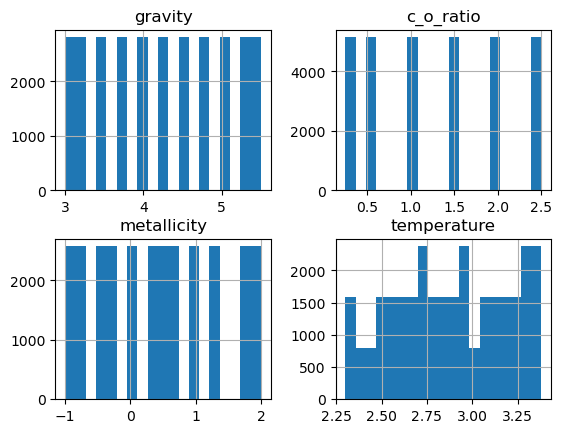

In [38]:
print( 'skewness:' )
display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(y[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
y.hist(grid=True, bins=19);

In [39]:
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Data Processing

In [40]:
# Create an instance of TrainCNNRegression
train_cnn_regression = TrainRegression(feature_values=X,
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

In [41]:
# Split the dataset into train and test sets
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [42]:
# normalize the X features using MinMax Scaler
train_cnn_regression.normalize_X_row_wise()

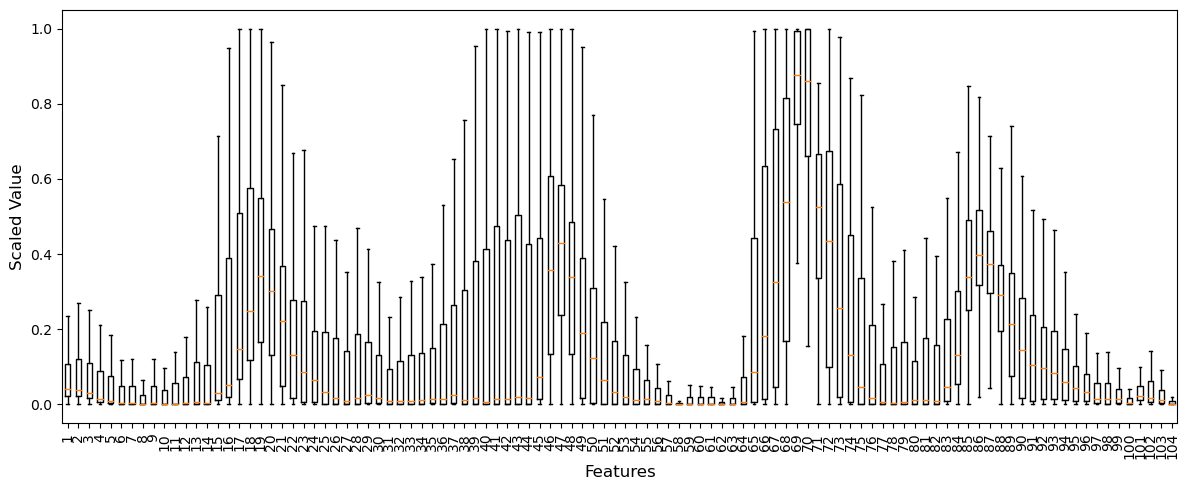

In [43]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_train_normalized_rowwise)

In [44]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

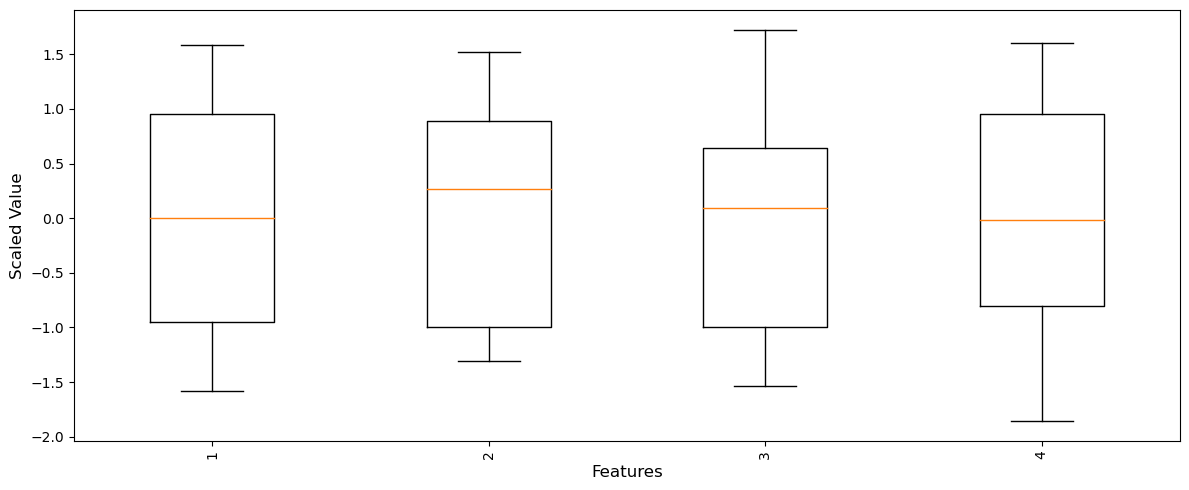

In [45]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.y_train_standardized_columnwise)

In [46]:
# train_cnn_regression.y_train_standardized_columnwise

In [47]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [48]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [49]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [50]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [51]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [52]:
df_MinMax_train

,min,max
28744,8.265340e-12,3.445259e-08
6288,8.080712e-22,8.397132e-14
13749,2.734403e-07,8.632182e-06
11713,4.414951e-16,3.373262e-10
15538,3.722576e-07,6.859888e-06
...,...,...
1806,3.537783e-10,2.404020e-07
10765,9.266921e-07,8.640541e-06
16472,3.583572e-12,1.047753e-07
27891,3.782887e-13,8.244911e-09


In [53]:
# plt.loglog(train_cnn_regression.X_train_max, 'k.', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train, 'r.', label='X_train', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train_min, 'r.', alpha = 0.4)

---

In [54]:
train_cnn_regression.standardize_X_column_wise(
                                                            X_train = df_MinMax_train.values,
                                                            X_val   = df_MinMax_val.values,
                                                            X_test  = df_MinMax_test.values,
                                                        )

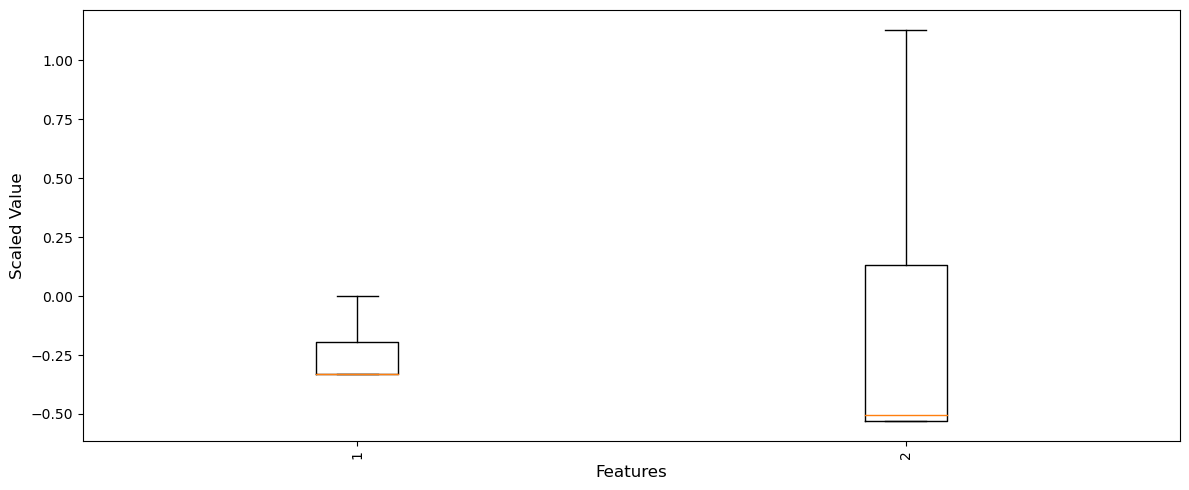

In [55]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_test_standardized_columnwise)

# Step 3: Train CNN model

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model architecture
input_1 = tf.keras.layers.Input(shape=(104, 1))
input_2 = tf.keras.layers.Input(shape=(2,))

model  = Conv1D(64*2, 3, 
                 kernel_initializer = 'he_normal', 
                 activation='relu', 
                 input_shape=(104, 1))(input_1)

model  = Conv1D(64*4, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = Conv1D(128*8, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = MaxPooling1D(2)(model)

model  = Conv1D(128*8, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = Conv1D(128*16, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)


model  = MaxPooling1D(2)(model)
model  = Flatten()(model)

model = tf.keras.layers.concatenate([model, input_2], 
                                                   name='Concatenated_Layer')


model  = Dense(128,                      
                kernel_initializer = 'he_normal',
                activation='relu')(model)

model  = Dense(128*4,                      
                kernel_initializer = 'he_normal',
                activation='relu')(model)

out__gravity =  Dense(1, 
                      activation='linear',
                name='gravity')(model)  # No activation function for regression

out__c_o_ratio = Dense(1, 
                      activation='linear',
                      name='c_o_ratio')(model)  # No activation function for regression

out__metallicity = Dense(1, 
                        activation='linear',
                        name='metallicity')(model)  # No activation function for regression

out__temperature = Dense(1, 
                        activation='linear',
                        name='temperature')(model)  # No activation function for regression

model = tf.keras.Model(inputs=[input_1, input_2], 
                               outputs=[out__gravity, out__c_o_ratio, out__metallicity, out__temperature])


# Compile the model with an optimizer, loss function, and metrics
model.compile(loss='huber_loss', 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),  
              metrics=['mae'])

# Train the model
history = model.fit(x = [train_cnn_regression.X_train_normalized_rowwise, 
                         train_cnn_regression.X_train_standardized_columnwise], 
          y = [train_cnn_regression.y_train_standardized_columnwise[:,0], 
               train_cnn_regression.y_train_standardized_columnwise[:,1],
               train_cnn_regression.y_train_standardized_columnwise[:,2],
               train_cnn_regression.y_train_standardized_columnwise[:,3]], 
          batch_size = 32, 
          epochs = 30, 
          validation_data=([train_cnn_regression.X_val_normalized_rowwise, 
                            train_cnn_regression.X_val_standardized_columnwise], 
                          [train_cnn_regression.y_val_standardized_columnwise[:,0], 
                           train_cnn_regression.y_val_standardized_columnwise[:,1],
                           train_cnn_regression.y_val_standardized_columnwise[:,2],
                           train_cnn_regression.y_val_standardized_columnwise[:,3]]))



Epoch 1/30
782/782 [==============================] - 724s 921ms/step - loss: 0.3359 - gravity_loss: 0.1269 - c_o_ratio_loss: 0.0762 - metallicity_loss: 0.1150 - temperature_loss: 0.0178 - gravity_mae: 0.3745 - c_o_ratio_mae: 0.2870 - metallicity_mae: 0.3726 - temperature_mae: 0.1264 - val_loss: 0.1704 - val_gravity_loss: 0.0571 - val_c_o_ratio_loss: 0.0396 - val_metallicity_loss: 0.0675 - val_temperature_loss: 0.0062 - val_gravity_mae: 0.2626 - val_c_o_ratio_mae: 0.2126 - val_metallicity_mae: 0.2890 - val_temperature_mae: 0.0906
Epoch 2/30
719/782 [==========================>...] - ETA: 57s - loss: 0.1325 - gravity_loss: 0.0365 - c_o_ratio_loss: 0.0284 - metallicity_loss: 0.0633 - temperature_loss: 0.0043 - gravity_mae: 0.1956 - c_o_ratio_mae: 0.1734 - metallicity_mae: 0.2772 - temperature_mae: 0.0723


KeyboardInterrupt



In [ ]:
train_cnn_regression.trained_model = model

# Save Trained Model

In [57]:
train_cnn_regression.trained_model.save('../../outputs/regression/trained_models/my_model_architecture__xNorm_yStand_MinMax.h5')
train_cnn_regression.trained_model.save_weights('../../outputs/regression/trained_models/my_model_weights__xNorm_yStand_MinMax.h5')

with open('../../outputs/regression/trained_models/training_history__xNorm_yStand_MinMax.pkl', 'wb') as file:
    pk.dump(history, file)
    


AttributeError: 'NoneType' object has no attribute 'save'

# Load Saved Models

In [60]:
model = load_model('../../outputs/regression/trained_models/my_model_architecture__xNorm_yStand_MinMax.h5')
model.load_weights('../../outputs/regression/trained_models/my_model_weights__xNorm_yStand_MinMax.h5')

# Loading the saved history object
with open('../../outputs/regression/trained_models/training_history__xNorm_yStand_MinMax.pkl', 'rb') as file:
    history = pk.load(file)    

In [61]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

# Step 3: Check Trained Model

---

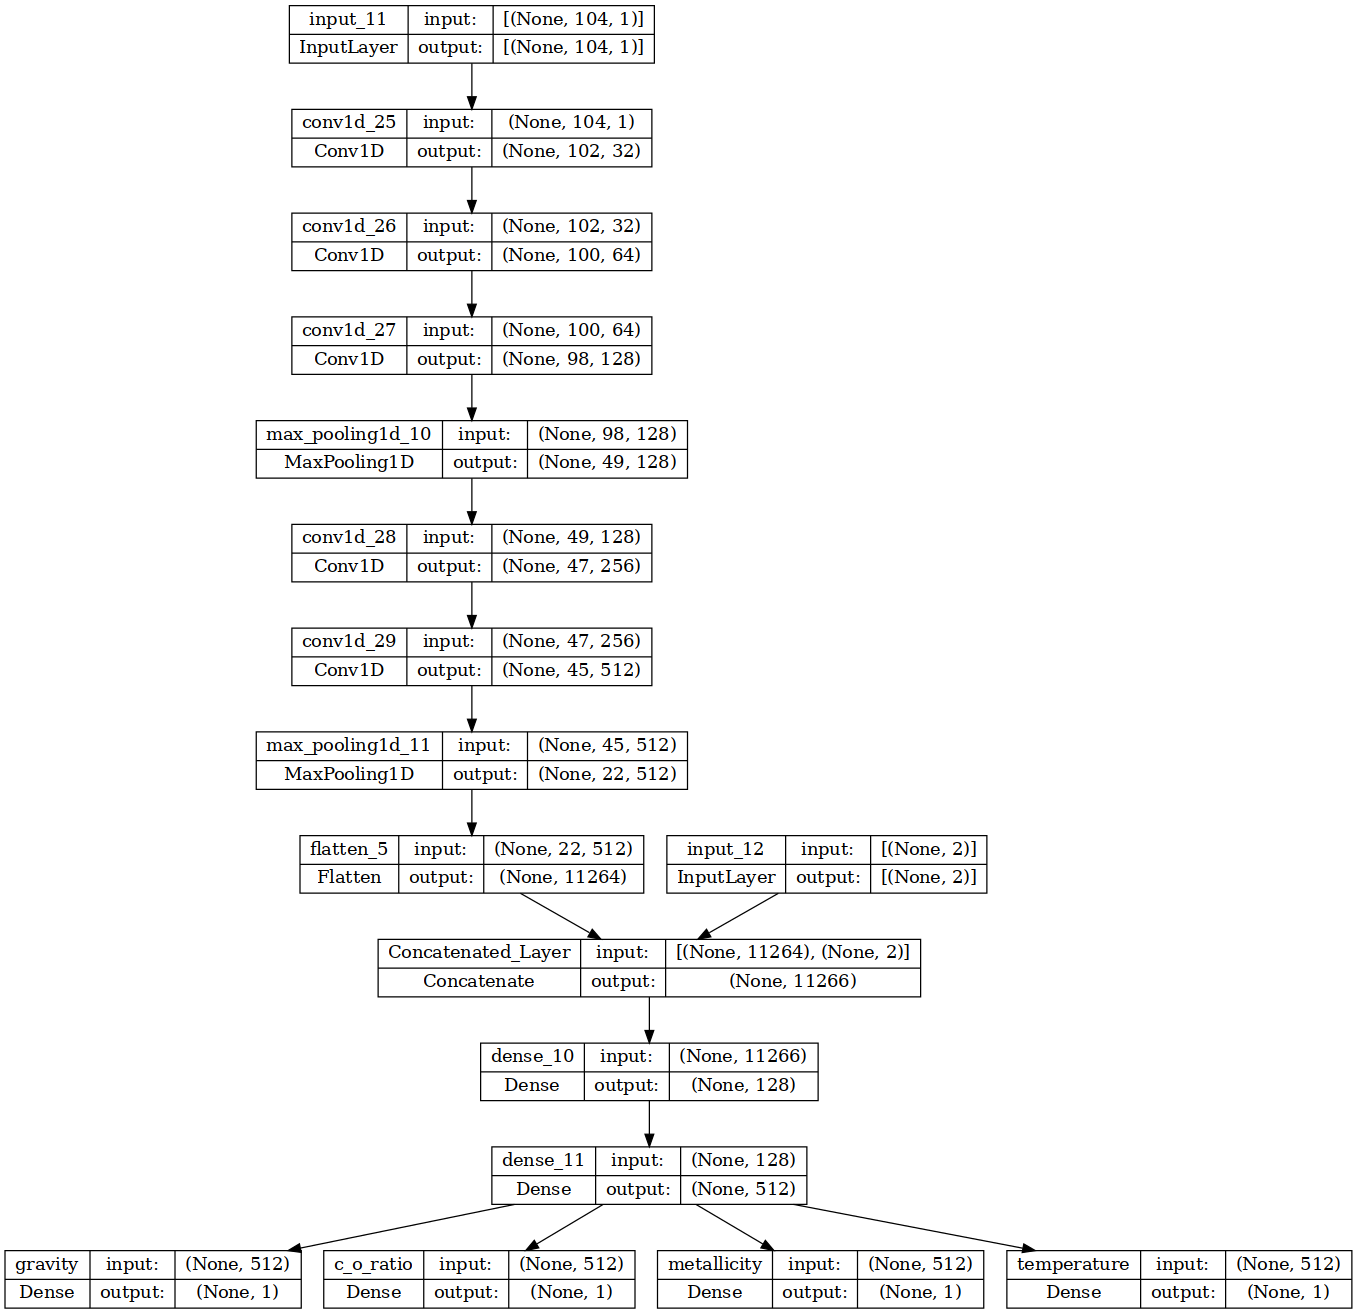

In [62]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
                show_layer_activations=False,
)

In [63]:
train_cnn_regression.trained_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 104, 1)]     0           []                               
                                                                                                  
 conv1d_25 (Conv1D)             (None, 102, 32)      128         ['input_11[0][0]']               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 100, 64)      6208        ['conv1d_25[0][0]']              
                                                                                                  
 conv1d_27 (Conv1D)             (None, 98, 128)      24704       ['conv1d_26[0][0]']              
                                                                                            

In [64]:
train_cnn_regression.plot_model_loss(title = 'X:NormRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Print outputs

In [65]:
# import pprint 
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(trained_cnn_model)

### Plot the trained CNN model archeticture 

### Plot Y predicted vs Y_Actual

In [66]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score

from scipy import stats
import seaborn as sns

def regression_report(trained_model, 
                      Xtrain, 
                      Xtest, 
                      ytrain, 
                      ytest,
                      target_i,
                          xy_top = [0.55, 0.85],
                          xy_bottom = [0.05, 0.8],
                          print_results = True):
    
    y_pred_train = np.array(trained_model.trained_model.predict(Xtrain) )[:,:,0].T
    y_pred_train_list = trained_model.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_list [:,3] = 10**y_pred_train_list[:,3]

    y_act_train_list = trained_model.standardize_y_ColumnWise.inverse_transform( ytrain )
    y_act_train_list [:,3] = 10**y_act_train_list[:,3]

    y_pred_test = np.array(trained_model.trained_model.predict(Xtest))[:,:,0].T
    y_pred_test_list = trained_model.standardize_y_ColumnWise.inverse_transform(y_pred_test)
    y_pred_test_list[:,3] = 10**y_pred_test_list[:,3]

    y_act_test_list = trained_model.standardize_y_ColumnWise.inverse_transform(ytest)
    y_act_test_list[:,3] = 10**y_act_test_list[:,3]

    
    
    for i in range(0,target_i):
        y_pred_train = y_pred_train_list[:,i]
        y_act_train = y_act_train_list[:,i]
            
        y_pred_test = y_pred_test_list[:,i]
        y_act_test = y_act_test_list[:,i]

            
        
        residual_train_list = y_pred_train - y_act_train
        residual_test_list = y_pred_test - y_act_test


        f, axs = plt.subplots(2,1,
                            figsize=(5,5),
                            sharey=False,
                            sharex=False,
                            gridspec_kw=dict(height_ratios=[1,3])
                            )

        r2_score_train = r2_score(y_pred_train , y_act_train)
        r2_score_test = r2_score(y_pred_test , y_act_test)

        rmse_score_train = np.sqrt( mean_squared_error(y_pred_train , y_act_train) )
        rmse_score_test = np.sqrt( mean_squared_error(y_pred_test , y_act_test) )

    #     print(mean_squared_error(y_pred_train[:,target_i] , ytrain[:,target_i]))

        mean_test = np.round(np.mean(residual_test_list),2)
        std_test = np.round(np.std(residual_test_list),2)
        mean_train = np.round(np.mean(residual_train_list),2)
        std_train = np.round(np.std(residual_train_list),2)



        skew_test = stats.skew(residual_test_list)
        skew_train = stats.skew(residual_train_list)

        if print:
            print('\n\n----------------------- Test ------------------------')
            print('R2: {:2.2f} \t  RMSE: {:2.2f} \t Mean+/-STD: {:2.2f}+/-{:2.2f}'.format(r2_score_test, rmse_score_train, mean_test, std_test))

            print('\n----------------------- Train ------------------------')
            print('R2: {:2.2f} \t  RMSE: {:2.2f} \t Mean+/-STD: {:2.2f}+/-{:2.2f}'.format(r2_score_train, rmse_score_test, mean_train, std_train))
            # print(' r2_score, rmse_score_test')
            # print(r2_score_train, rmse_score_train)
            # print('------ mean, std -----------')
            # print( mean_train, std_train)
            # print('------- Skewness -----------')
            # print(skew_train)
            # print('------------------\n\n\n')

        axs[0].set_title(['Gravity','C_O_ratio', 'Metallicity', 'Temperature'][i],fontsize = 14)

        sns.histplot(data= residual_train_list, 
                    ax=axs[0],
                    label='train', 
                    alpha = 0.7, bins=19, log_scale=False, stat='percent', legend=True, linewidth=0
                    )

        sns.histplot(data= residual_test_list, 
                    label='test', 
                    ax=axs[0],
                    alpha = 0.3, bins=19, stat='percent', legend=True,linewidth=0
                )

        axs[0].set_xlim((-(abs(mean_train)+3*std_train),(abs(mean_train)+3*std_train)))
        axs[0].set_ylim((1e-1,100))
        axs[0].set_yscale('log')
        axs[0].set_ylabel('Probability %', fontsize = 12)

        # yact = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(ytrain))[:,target_i]
        # ypred = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(cnn_model.trained_model.predict(Xtrain))[:,:,0].T )[:,target_i]
        sns.scatterplot(
                    y = y_pred_train,
                    x = y_act_train,
                    label='train', 
                    ax=axs[1],
                    alpha = 0.7, 
                    legend=False,
                    )

        # yact = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(ytest))[:,target_i]
        # ypred = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(cnn_model.trained_model.predict(Xtest))[:,:,0].T )[:,target_i]
        sns.scatterplot(
                    y = y_pred_test,
                    x = y_act_test,
                    label = 'test', 
                    ax = axs[1],
                    alpha = 0.7, legend=False,
                    )
        # axs[1].set_xlim((min(y_pred_train),max(y_pred_train)))



        axs[1].set_ylabel('Predicted value', fontsize = 12)
        axs[1].set_xlabel('Actual value', fontsize = 12)


        axs[0].annotate(r'$\tilde{\mu}_{{\rm 3, train}}$= '+f'{np.round(skew_train,2)}', 
                            fontsize=11, xy=(xy_top[0],xy_top[1]+0.08), xycoords='axes fraction')
        axs[0].annotate(r'$\tilde{\mu}_{{\rm 3, test}}$ = '+f'{np.round(skew_test,2)}', 
                            fontsize=11, xy=(xy_top[0],xy_top[1]-0.08), xycoords='axes fraction')

        axs[1].annotate(r'R$^2_{\rm train}$='+f'{"%0.2f"%r2_score_train} [{"%0.2f"%abs(mean_train)}$\pm${"%0.2f"%std_train}]', 
                            fontsize=11, xy=(xy_bottom[0],xy_bottom[1]+0.06), xycoords='axes fraction')
        axs[1].annotate(r'R$^2_{\rm test}$ ='+f'{np.round(r2_score_test,2)} [{"%0.2f"%mean_test}$\pm${"%0.2f"%std_test}]',
                            fontsize=11, xy=(xy_bottom[0],xy_bottom[1]-0.06), xycoords='axes fraction')





        axs[1].legend(loc='lower right', fontsize = 11)
        # plt.yscale('log')

        f.tight_layout()
        plt.show()

In [67]:
i = 1
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_normalized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_normalized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )

 10/782 [..............................] - ETA: 2:25


KeyboardInterrupt



---X_test_normalized_rowwise

# Step 4: Predict Observational data using the trained model

## ROSS 458C

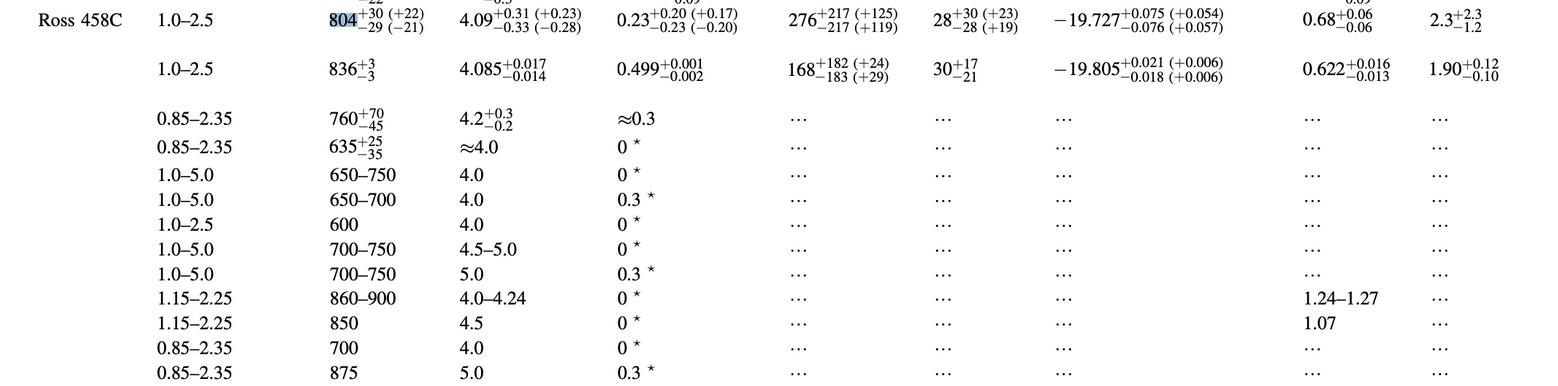

### Load X and y StandardScaler Operators

In [68]:
fluxcal = pd.read_csv(f'../../datasets/observational_spectra/GJ570D_fluxcal.dat', 
                   delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                   usecols=(0,1,2))#.dropna(inplace=True)

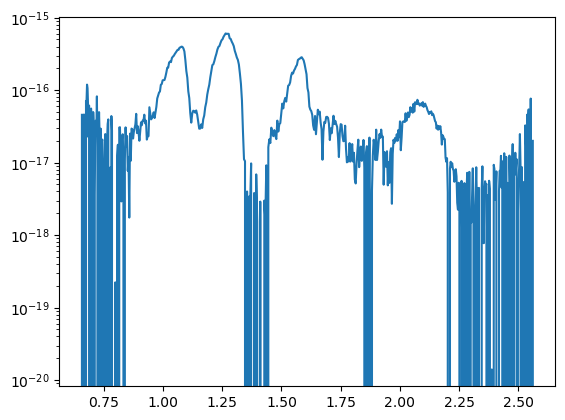

In [69]:
plt.semilogy( fluxcal['wl'],fluxcal['F_lambda'])

In [70]:
fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
fluxcal['F_lambda'].interpolate(inplace=True)

In [71]:
bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                 feature_names_obs  = fluxcal['wl'].values, 
                                 feature_names_synthetic = wl['wl'].values,
                                )

object_name = 'GJ570D'
# add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
if object_name == 'Ross458C':
    bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
if object_name == 'HD3651B':
    bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
if object_name == 'GJ570D':
    bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




bd_object.flux_interpolated(print_results=False, 
                            plot_results=True,
                            use_spectres=True
                           )
bd_object.df_flux_object     

# print(bd_object.df_flux_object[::-1] )

,0.897,0.906,0.915,0.924,0.933,0.943,0.952,0.962,0.971,0.981,...,2.296,2.319,2.342,2.366,2.389,2.413,2.438,2.462,2.487,2.512
0,7.280711e-09,8.611113e-09,1.062637e-08,1.170489e-08,7.329417e-09,1.371097e-08,1.299396e-08,1.443783e-08,1.943760e-08,2.911763e-08,...,7.612835e-09,6.693866e-09,8.187037e-09,8.760881e-09,8.572828e-09,1.231363e-08,1.863393e-08,1.684466e-08,2.206102e-08,1.915624e-08


### Create Min Max features


In [72]:
bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

xxx2

array([[-0.32652208, -0.42998764]])

### Create normalized X_obs 

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

In [73]:
X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
X_scaled = X_std * (1. - 0.) + 0.

In [74]:
X_scaled = X_scaled[::-1].reshape(1,104)

In [75]:
y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled,xxx2]) )[:,:,0].T
y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
y_pred = y_pred_train_

1/1 [==============================] - 0s 198ms/step


In [76]:
y_pred

array([[ 5.0467806e+00,  1.4681592e+00, -4.4472024e-01,  8.3113080e+02]],
      dtype=float32)

In [107]:
import pandas as pd
import numpy as np
nearest_value_list = []

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value
            nearest_value_list.append(nearest_value)

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return nearest_value_list, filtered_df

# Print the filtered DataFrame

# Filter the DataFrame and get the result
# nearest_value1, filtered_df1 = filter_dataframe(df, targets)
# display(filtered_df1)


#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================

# Specify target values
# Create the figure


def plot_predicted_vs_observed(data = df, 
                               targets = targets,
                               object_name = 'GJ570D',):
    
    nearest_value1, filtered_df1 = filter_dataframe(data, targets)

    p = figure(title=f'{object_name} [XNorm, yStand] Predicted: '+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(y_pred[0][i],2)) for i in  range(4)]), 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type = 'log')

    # Add the scatter plot
    p.line(x =wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0], 
           line_width = 1,
           legend_label='Modeled:'+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(nearest_value1[i],2)) for i in  range(4)]))
    p.circle(x = wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0],
           line_width = 2,
           # legend_label='Observation'
            )



    p.line(x =wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
           line_color = 'orange', line_width = 2,
           legend_label='Observation')

    # Increase size of x and y ticks
    p.title.text_font_size = '12pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.xaxis.axis_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'


    p.legend.location = "bottom_right"
    p.legend.background_fill_color = 'white'
    p.legend.background_fill_alpha = 0.5

            # Add the error bars using vbar
    # p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

    # Show the plot
    show(p)

In [108]:
# df_interpolated = pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2__interpolated_all.csv',
#                                compression = 'zip')


In [109]:
# df_interpolated.iloc[:,:-5]

In [110]:
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )

plot_predicted_vs_observed(df, 
                               targets,
                               object_name = 'GJ570D',)

5.0
1.5
-0.5
850


In [51]:
import pandas as pd
import numpy as np

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return filtered_df

# Specify target values
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# Print the filtered DataFrame

# Filter the DataFrame and get the result
filtered_df1 = filter_dataframe(df, targets)
display(filtered_df1)

targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [4, 1, 0, 900]) )
filtered_df2 = filter_dataframe(df, targets)
# display(filtered_df2)


5.0
1.5
-0.5
850


,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
22790,5.0,850,1.5,-0.5,1.881976e-08,2.149493e-08,1.926617e-08,1.365548e-08,1.057516e-08,6.403168e-09,...,2.238516e-08,1.593970e-08,1.392989e-08,1.318570e-08,7.635196e-09,1.113877e-08,1.003160e-08,7.679517e-09,4.461058e-09,no


In [76]:
fluxcal

,wl,F_lambda,F_lambda_error
0,0.657971,4.569383e-17,7.119990e-17
1,0.660155,4.581152e-17,0.000000e+00
2,0.662332,4.592921e-17,0.000000e+00
3,0.664501,4.604690e-17,0.000000e+00
4,0.666665,4.616459e-17,8.804178e-17
...,...,...,...
555,2.548700,6.909362e-17,0.000000e+00
556,2.551630,7.652011e-17,6.939810e-17
557,2.554570,5.767152e-17,0.000000e+00
558,2.557520,3.882293e-17,0.000000e+00


In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

def plot_spectra_errorbar(object_name, x, y, error):
    # # Sample data
    # x = fluxcal['wl']
    # y = fluxcal['F_lambda']
    # error = fluxcal['F_lambda_error']

    # Calculate the error bar coordinates
    x_err = x
    y_err = y
    upper = [y_val + err_val for y_val, err_val in zip(y, error)]
    lower = [y_val - err_val for y_val, err_val in zip(y, error)]

    # Create a ColumnDataSource to store the data
    source = ColumnDataSource(data=dict(x=x, y=y, x_err=x_err, y_err=y_err, upper=upper, lower=lower))

    # Create the figure
    p = figure(title=object_name+': Calibrated Observational Spectra', 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type='log')

    # Set the font size for axis labels and tick labels
    p.xaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    # Add the scatter plot
    p.scatter('x', 'y', source=source, legend_label='Data')

    # Add the error bars using vbar
    p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='gray', line_alpha = 0.4)

    # Show the plot
    output_notebook()
    show(p)


---

In [ ]:
import seaborn as sns
def boxplot_hist(data, x_label, xy_loc):
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.histplot(data, ax=ax_hist, kde=True, stat='probability')
    sns.boxplot(x = data, ax=ax_box, showmeans=True, meanline = True,
                meanprops={"marker": "|",
                           "markeredgecolor": "white",
                           "markersize": "30", 
                            }
                       )
    
    fig.set_figheight(3)
    fig.set_figwidth(3)

    ax_box.set(xlabel='')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set_yticks([])

    mean = np.round(np.mean(data),2)
    std = np.round(np.std(data),2)
    plt.annotate(f'{x_label}='+str(np.round(mean,2))+'$\pm$'+str(np.round(std,2)), fontsize=11, 
                 xy=(xy_loc[0], xy_loc[1]), xycoords='axes fraction')
                    
    plt.xlabel(x_label, fontsize = 12)

    plt.show()

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

# Define the observed values and uncertainties for each list
list1_values = [10, 15, 5, 8, 12]
list1_uncertainties = [0.5, 0.7, 0.3, 0.6, 0.4]

list2_values = [8, 12, 9, 6, 15]
list2_uncertainties = [0.6, 0.8, 0.4, 0.7, 0.5]

list2_values = [8, 12, 9, 90, 20]
list2_uncertainties = [0.6, 0.8, 0.4, 0.7, 0.5]

# Create the weighted contingency table
weighted_values = np.array([list1_values, list2_values])
weights = np.array([list1_uncertainties, list2_uncertainties])
weighted_table = np.divide(weighted_values, weights, where=weights != 0)

# Perform the weighted chi-squared test
chi2, p, dof, expected_values = chi2_contingency(weighted_table)

# Print the results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected values:")
for row in expected_values:
    print(row)


Chi-squared statistic: 63.560186251970805
P-value: 5.172388102192466e-13
Degrees of freedom: 4
Expected values:
[10.5380334  11.51656507 12.38218924 44.8619136  22.12987013]
[22.79529994 24.91200636 26.78447743 97.04284831 47.87012987]


In [ ]:
import random
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis
from bokeh.palettes import  viridis, inferno
       

    
def PredictObsParametersRegression2(object_name, 
                                    predict_from_random_spectra = True,
                                    random_spectra_num=10,
                                    print_results = False,
                                    plot_randomly_generated_spectra = False,
                                    print_df_describe = False,
                                    plot_histogram = False,
                                    plot_observational_spectra_errorbar = True,
                                    plot_boxplot_hist = True,
                                    plot_predicted_vs_observed_ = True,
                                   ):


    spectra_list = []
    param_list = []    
    color = viridis(101).__iter__()


    fluxcal = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                       delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                       usecols=(0,1,2))#.dropna(inplace=True)

    fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
    fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
    fluxcal['F_lambda'].interpolate(inplace=True)

    bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                     feature_names_obs  = fluxcal['wl'].values, 
                                     feature_names_synthetic = wl['wl'].values,
                                    )
    
    if plot_observational_spectra_errorbar:
        plot_spectra_errorbar(object_name, 
                              x = fluxcal['wl'], 
                              y = fluxcal['F_lambda'],
                              error = fluxcal['F_lambda_error'])
    

    # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
    if object_name == 'Ross458C':
        bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
    if object_name == 'HD3651B':
        bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
    if object_name == 'GJ570D':
        bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




    bd_object.flux_interpolated(print_results=False, 
                                plot_results=True,
                                use_spectres=True
                               )
    bd_object.df_flux_object     


    
    # ********************************* 
    bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
    bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

    df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

    xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)


    X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
    X_scaled = X_std * (1. - 0.) + 0.
    #     bd_mean = bd_object.df_flux_object.mean(axis=1)[0]  
    #     bd_std = bd_object.df_flux_object.std(axis=1)[0]     

    #     X_scaled = (bd_object.df_flux_object.values[0] - bd_mean) / bd_std

    y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0))[:,:,0].T
    y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    y_pred = y_pred_train_

    
    
    # Specify target values
    # Create the figure
    
    if plot_predicted_vs_observed_:
        # print(df)
        targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
        
        plot_predicted_vs_observed(df, 
                                   targets = targets,
                                   object_name = object_name)
    
        
        
    if predict_from_random_spectra:
        for i in range(random_spectra_num):
            # Comment from Natasha: 
            spectra = pd.DataFrame( np.random.normal(fluxcal['F_lambda'] , fluxcal['F_lambda_error'] ) ,
                                     columns=['F_lambda'])
            # spectra = pd.DataFrame( [random.uniform(fluxcal.F_lambda[i]-1*fluxcal.F_lambda_error[i], 
                                 # fluxcal.F_lambda[i]+1*fluxcal.F_lambda_error[i]) 
                                 # for i in range(len(fluxcal))],columns=['F_lambda'] )
            
            



            # Process the dataset
            spectra['F_lambda'] = spectra['F_lambda'].mask(spectra['F_lambda'].lt(0),0)
            spectra['F_lambda'].replace(0, np.nan, inplace=True)
            spectra['F_lambda'].interpolate(inplace=True)


            # Instintiate Process Observational Dataset class
            bd_object_generated = ProcessObservationalDataset( feature_values_obs = spectra['F_lambda'].values,
                                             feature_names_obs  = fluxcal['wl'].values, 
                                             feature_names_synthetic = wl['wl'].values,
                                            )


            # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
            if object_name == 'Ross458C':
                bd_object_generated.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
            if object_name == 'HD3651B':
                bd_object_generated.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
            if object_name == 'GJ570D':
                bd_object_generated.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    
    



            bd_object_generated.flux_interpolated(print_results=False, 
                                        plot_results=False,
                                        use_spectres=True
                                       )
            bd_object_generated.df_flux_object    
    
            # bd_object_generated.flux_interpolated(print_results=False, plot_results=False)
            # bd_object_generated.df_flux_object.values
            spectra_list.append(bd_object_generated.df_flux_object.values)
            
            # ********************************* 
            bd_object_generated.df_flux_object_min = bd_object_generated.df_flux_object.min(axis=1)
            bd_object_generated.df_flux_object_max = bd_object_generated.df_flux_object.max(axis=1)

            df_MinMax_obs = pd.DataFrame(( bd_object_generated.df_flux_object_min, bd_object_generated.df_flux_object_max)).T

            xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

            
            X_std = (bd_object_generated.df_flux_object.values[0] - bd_object_generated.df_flux_object.min(axis=1)[0]) / (bd_object_generated.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
            X_scaled = X_std * (1. - 0.) + 0.


            y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0) )[:,:,0].T
            y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
            y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
            y_pred = y_pred_train_
            # ********************************* 


    
    
            param_list.append(  y_pred[0] )

        df_random_pred = pd.DataFrame(param_list, columns=['logg' ,'c_o' ,'met' ,'T'] )
        display(df_random_pred.describe())
            
        if print_results:
            print(param_list)

        if plot_randomly_generated_spectra:
            p = figure(title=object_name+": Randomly generated spectra within 1σ", 
                       x_axis_label='features [wavelengths]', y_axis_label='Flux (Fν)',
                       width=1000, height=300,
                       y_axis_type="log", background_fill_color="#fafafa"
                      )
            

            for i in range(0,random_spectra_num,1):
                    p.line(wl.wl.values[::-1],spectra_list[i][0], 
                           line_width = 1,
                           line_alpha = 0.6, 
                           line_color=next(color),
                           )

                    
                    
        # Set the font size for axis labels and tick labels
        p.xaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'
        show(p)

            
        if print_df_describe:
            display(df_random_pred.describe())
            
            
        if plot_histogram:
            plt.figure()
            df_random_pred.hist()
            plt.show()
        
        if plot_boxplot_hist: 
            boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['met'], x_label=r'[M/H]', xy_loc=[0.05,0.98],)
            

    return df_random_pred

        

            
            

---

# GJ570D

Loading BokehJS ...

5.0
1.5
-0.5
850


,logg,c_o,met,T
count,10.000000,10.000000,10.000000,10.000000
mean,5.023582,1.508421,-0.434103,841.722473
std,0.154594,0.115708,0.075526,28.693037
min,4.843429,1.312797,-0.583439,796.989807
25%,4.915266,1.435848,-0.470957,822.328903
50%,5.010313,1.522021,-0.446663,839.991089
75%,5.088025,1.610368,-0.372077,857.838943
max,5.367370,1.628057,-0.322794,894.134094


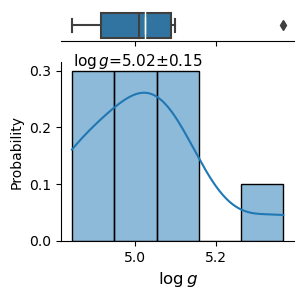

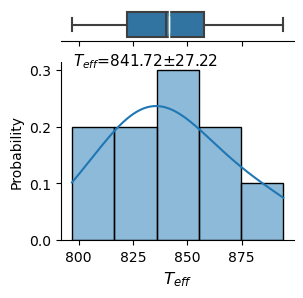

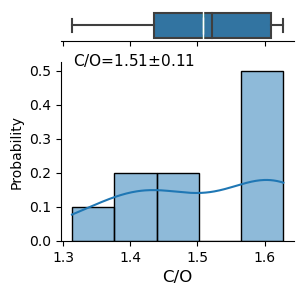

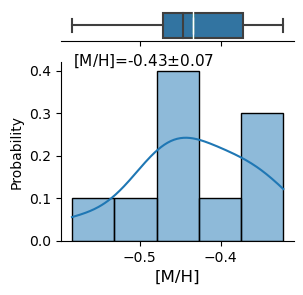

In [ ]:
df_random_pred = PredictObsParametersRegression2(object_name = 'GJ570D', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=10,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True,
                                                plot_predicted_vs_observed_ = True

                                                            )

---

# HD3651B

Loading BokehJS ...

4.75
1.5
-0.5
800


,logg,c_o,met,T
count,20.000000,20.000000,20.000000,20.000000
mean,4.822633,1.432662,-0.486770,815.364258
std,0.158744,0.133062,0.097465,19.207184
min,4.545689,1.159700,-0.627921,788.441589
25%,4.730732,1.332496,-0.548401,798.100067
50%,4.833516,1.467468,-0.509302,817.026093
75%,4.939332,1.523860,-0.451415,827.503601
max,5.119747,1.632194,-0.241970,855.491943


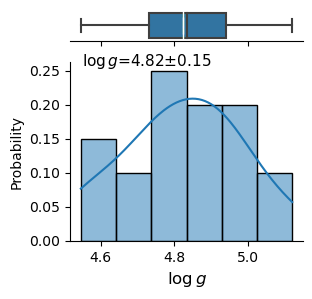

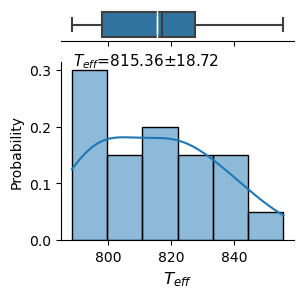

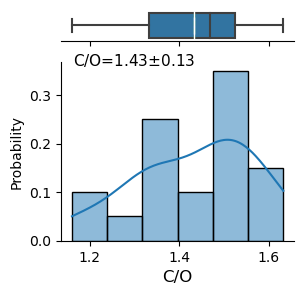

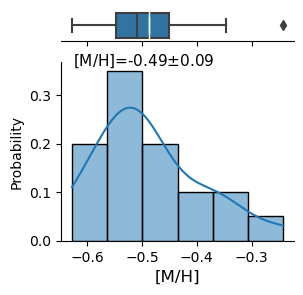

In [ ]:
df_random_pred = PredictObsParametersRegression2(object_name = 'HD3651B', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=20,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True,
                                                plot_predicted_vs_observed_ = True

                                                            )

---

# Ross458C

Loading BokehJS ...

4.0
1.5
-0.5
900


,logg,c_o,met,T
count,20.000000,20.000000,20.000000,20.000000
mean,3.774704,1.901912,-0.319037,909.230774
std,0.284177,0.355529,0.247013,28.045422
min,3.368621,1.305373,-0.652359,868.992676
25%,3.540080,1.622522,-0.470014,882.248184
50%,3.686103,1.874197,-0.401311,900.223999
75%,4.024912,2.252701,-0.161859,932.439346
max,4.314487,2.325260,0.374611,958.019287


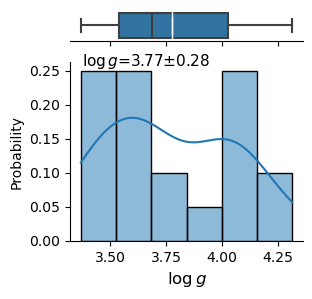

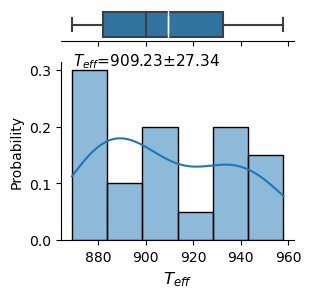

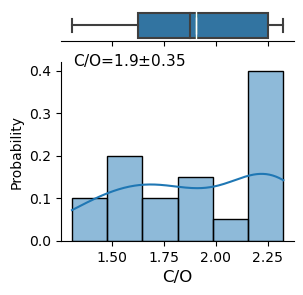

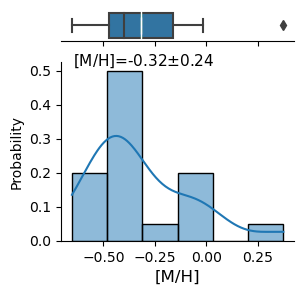

In [57]:
df_random_pred = PredictObsParametersRegression2(object_name = 'Ross458C', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=20,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True,
                                                plot_predicted_vs_observed_ = True

                                                            )

---